In [19]:
import numpy as np
#from graspy.inference import NonparametricTest
from graspy.simulations import sbm
from graspy.plot import heatmap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [12]:
import numpy as np
from scipy.spatial.distance import pdist
from scipy.stats import norm

from graspy.embed import AdjacencySpectralEmbed, LaplacianSpectralEmbed, OmnibusEmbed, select_dimension
from graspy.utils import import_graph, is_symmetric, symmetrize

class NonparametricTest(): #BaseInference
    """
    Two sample hypothesis test for the nonparamatric problem of determining
    whether two random dot product graphs have the same latent positions.
    Parameters
    ----------
    embedding : string, { 'ase' (default), 'lse', 'omnibus'}
        String describing the embedding method to use.
        Must be one of:
        'ase'
            Embed each graph separately using adjacency spectral embedding
            and use Procrustes to align the embeddings.
        'lse'
            Embed each graph separately using laplacian spectral embedding
            and use Procrustes to align the embeddings.
        'omnibus'
            Embed all graphs simultaneously using omnibus embedding.
    n_components : None (default), or Int
        Number of embedding dimensions. If None, the optimal embedding
        dimensions are found by the Zhu and Godsi algorithm.
    n_bootstraps : 200 (default), or Int
        Number of bootstrap iterations.
    monte_iter : 1000 (default), or Int
        Number of monte carlo iterations.
    """
    def __init__(self, embedding='ase', n_components=None, n_bootstraps=200, n_monte=1000,):
        if type(n_bootstraps) is not int:
            raise TypeError()

        if n_bootstraps < 1:
            raise ValueError('{} is invalid number of bootstraps, must be greater than 1'.format(n_bootstraps))

        #super().__init__(embedding=embedding, n_components=n_components,)
        self.embedding = embedding
        self.n_components = n_components
        self.n_bootstraps = n_bootstraps
        self.n_monte = n_monte

    def _bootstrap(self,x,y,n_boot=200):
        z = np.concatenate((x,y))
        boots = []
        for _ in range(n_boot):
            np.random.shuffle(z)
            u = self._u_from_z(z,len(x))
            boots.append(u)
        return boots

    def _u_from_z(self,z,n):
        k = self._dist_matrix(z)
        gk = np.exp(-k/np.median(k))
        u = np.mean(gk[:n,:n]) + np.mean(gk[n:,n:]) -2*np.mean(gk[:n,n:])
        return u

    def _dist_matrix(self,z):
        dists = pdist(z, 'euclidean')
        zlen = len(z)
        ind = np.triu_indices(zlen,k=1)
        k = np.zeros((zlen,zlen))
        k[ind] = dists
        return symmetrize(k)

    def _embed(self, A1, A2):
        if self.embedding not in ['ase', 'lse', 'omnibus']:
            raise ValueError('Invalid embedding method "{}"'.format(self.embedding))
        if self.embedding == 'ase':
            X1_hat = AdjacencySpectralEmbed(self.n_components).fit_transform(A1)
            X2_hat = AdjacencySpectralEmbed(self.n_components).fit_transform(A2)
        elif self.embedding == 'lse':
            X1_hat = LaplacianSpectralEmbed(self.n_components).fit_transform(A1)
            X2_hat = LaplacianSpectralEmbed(self.n_components).fit_transform(A2)
        elif self.embedding == 'omnibus':
            X_hat_compound = OmnibusEmbed(self.n_components).fit_transform((A1, A2))
            X1_hat = X_hat_compound[:A1.shape[0],:]
            X2_hat = X_hat_compound[A2.shape[0]:,:]

        return (X1_hat, X2_hat)

    def _median_heuristic(self, X_hats):
        X1_hat = X_hats[0]
        X2_hat = X_hats[1]
        X1_med = np.median(X1_hat,axis=0)
        X2_med = np.median(X2_hat,axis=0)
        #if sign of median is off, multiply by -1
        opp = np.multiply(X1_med,X2_med) >= 0
        opp2 = [int(o)*2-1 for o in opp] #1 if mean same sign, -1 if not
        X2_hat = np.multiply(X2_hat,opp2)
        return (X1_hat, X2_hat)

    def fit(self, A1, A2):
        A1 = import_graph(A1)
        A2 = import_graph(A2)
        if not is_symmetric(A1) or not is_symmetric(A2):
            raise NotImplementedError() # TODO asymmetric case

        if self.n_components is None:
            num_dims1 = select_dimension(A1)[0][-1]
            num_dims2 = select_dimension(A2)[0][-1]
            self.n_components = max(num_dims1, num_dims2)

        #monte = [] TODO
        #for _ in range(self.n_monte): TODO
        X_hats = self._embed(A1, A2)
        X_hats = self._median_heuristic(X_hats)
        U_sample = self._u_from_z(np.concatenate(X_hats), len(X_hats[0]))
        U_bootstrap = self._bootstrap(X_hats[0],X_hats[1])

        self.U_bootstrap = U_bootstrap
        self.U_sample = U_sample
        return U_sample

In [25]:
A = sbm([50,50],np.array([[.9,.1],[.1,.9]]))
B = sbm([50,50],np.array([[.7,.4],[.4,.7]]))

In [38]:
def test_nonpar(A,B):
    nonpar = NonparametricTest()
    nonpar.fit(A,B)
    dist = nonpar.U_bootstrap
    sample = nonpar.U_sample
    crit = np.percentile(dist,95)
    heatmap(A)
    heatmap(B)
    ax = plt.subplots(figsize=(10,6))[1]
    sns.distplot(dist, ax=ax)
    ax.axvline(crit, linestyle='--',
               color='black', linewidth=2)
    ax.axvline(sample, linestyle='--',
               color='red', linewidth=2)
    plt.title('black = critical value, red = our sample')
    plt.show()

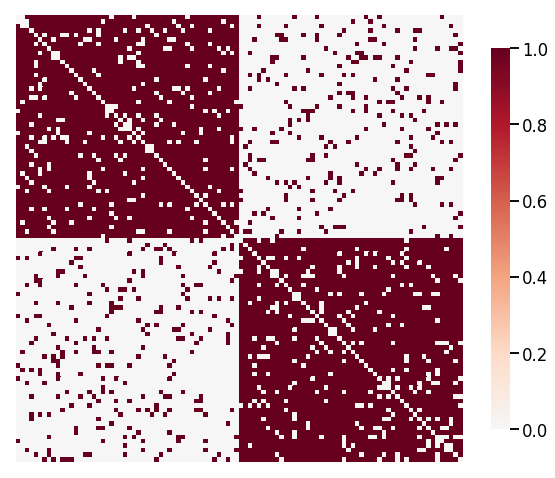

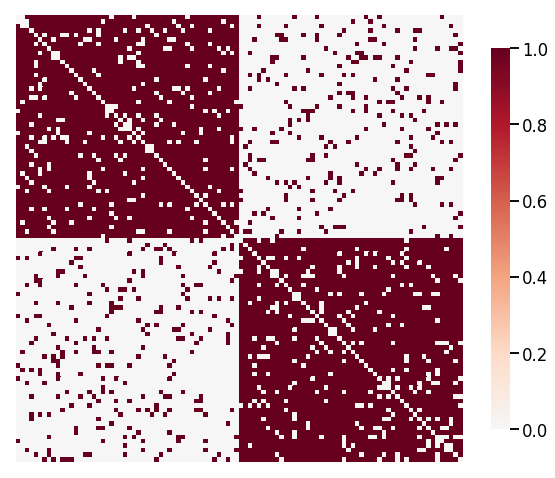

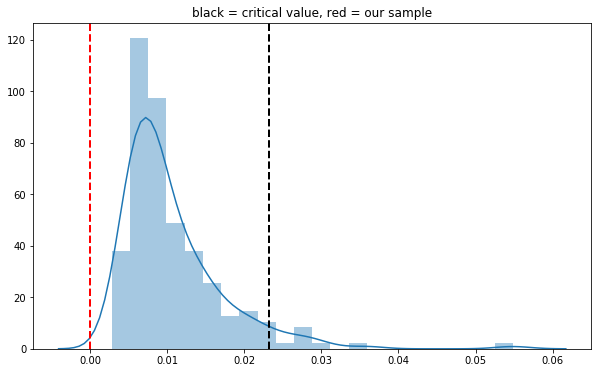

In [39]:
test_nonpar(A,A)

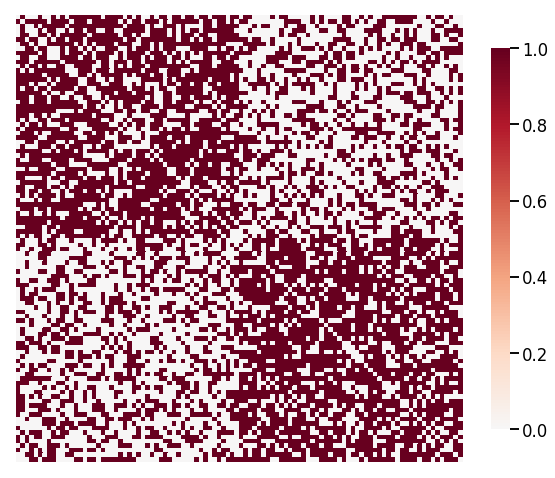

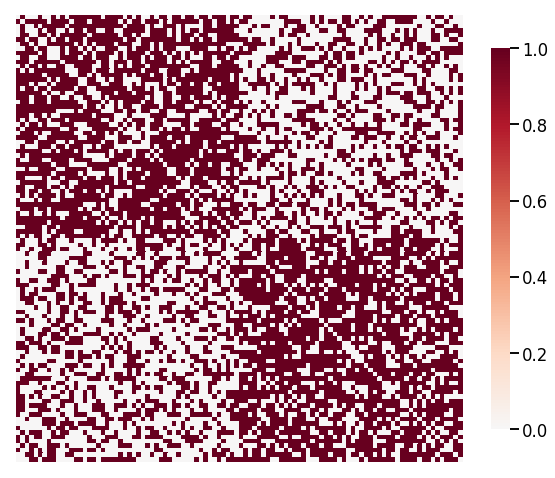

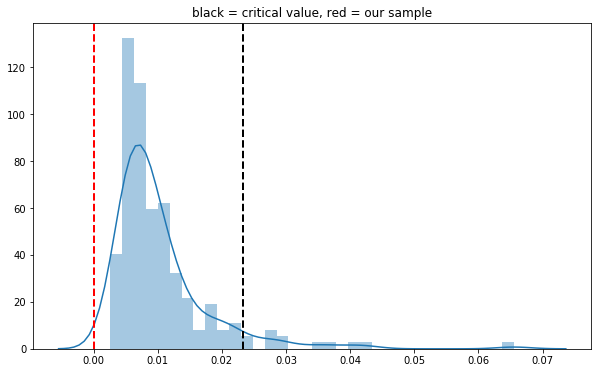

In [34]:
test_nonpar(B,B)

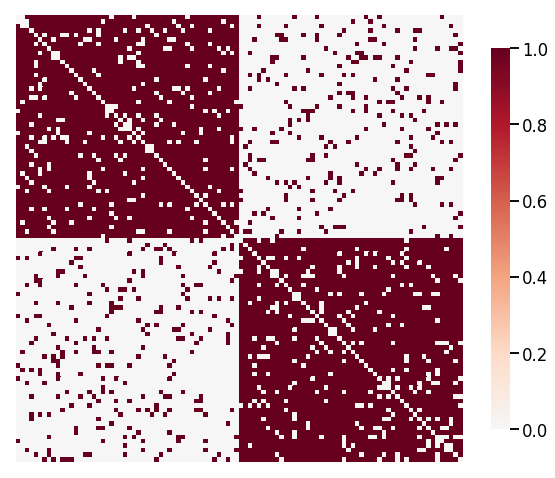

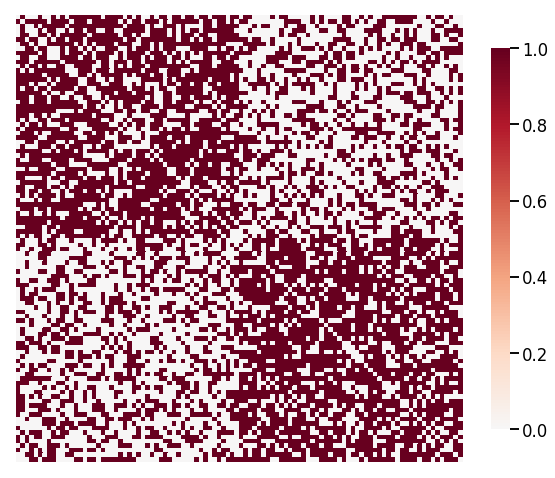

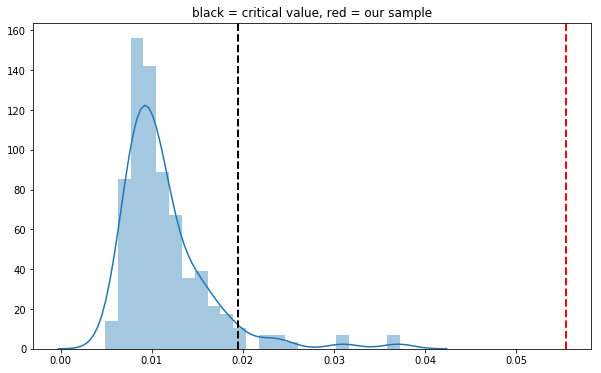

In [35]:
test_nonpar(A,B)